
## Barcamp Flensburg 2017

# Analyse des Anmeldeverhaltens mit Jupyter Notebooks

Am 08.Februar 2017 wurde die Anmeldung für das zweite Flensburger Barcamp eingeschaltet.

<img src="vortrag_01.jpg">

Sofort nach der Anmeldung habe ich mir überlegt, was eine gute Sessionidee wäre. Irgendetwas mit mit Daten, am Besten mit Barcamp-Bezug. Vielleicht etwas über das Anmeldevorgang selbst?

<img src="vortrag_02.jpg">

Als Vorbereitung habe ich mich daher mit meinem Raspberry Pi verbunden und ein schnelles Skript geschrieben, dass die Anmeldeseiten des Barcamps sichert. 

Das Skript sah so aus:



    url_sa = r'https://events.wireg.de/event/oKwrLADA/guestlist'
    url_fr = r'https://events.wireg.de/event/nAQD9464/guestlist'
    url_saw = r'https://events.wireg.de/event/oKwrLADA/enter'
    url_frw = r'https://events.wireg.de/event/nAQD9464/enter'

    import urllib2
    import datetime
    import os
    import sys

    def save_bcfl(url, tag, pfad=None):
        response = urllib2.urlopen(url, None, 60)
        html = response.read()
        filename = '{}_{}.html'.format(tag, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M'))
        with open(os.path.join(pfad,filename), 'w') as w1:
            w1.write(html)

    if __name__ == '__main__':
        save_bcfl(url_fr, 'fr', sys.argv[1])
        save_bcfl(url_sa, 'sa', sys.argv[1])
        save_bcfl(url_frw, 'w_fr', sys.argv[1])
        save_bcfl(url_saw, 'w_sa', sys.argv[1])


Über die komplette Anmeldeperiode habe ich die Daten gesammelt, die nachfolgend dann ausgewertet werden.


# Hinweis

Das Ziel dieses Vortrags ist es, einen ersten Einblick in die Arbeit mit Jupyter Notebooks zu geben.

Damit das auch für Programmieranfänger halbwegs verständlich ist, habe ich versucht, den Python-Code relativ einfach zu halten und auf performantere Libraries wie Pandas verzichtet.

Das Bespiel verwendet Python 3.6 und benötigt Jupyter (inkl ipywidgets), Matplotlib & requests.


# Teil 1 - Erste Analyse

Nachfolgende Module von Python werden benutzt und müssen daher importiert werden

In [1]:
import os
import re
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# pip install ipywidgets
# jupyter nbextension enable --py --sys-prefix widgetsnbextension
from ipywidgets import FloatProgress
from IPython.display import display


Hier liegen die Dateien lokal vor.

Der Verzeichnisname "barcamp" ist für diese Beispiele notwendig.


In [45]:
_PATH = r'..\barcamp'

Da es immer wieder nötig ist, die gesammeten Dateien zu verwenden, schreibe ich zunächst ein Funktion, die mir diese zur Verfügung stellt


In [46]:
def get_filenames(path, day, typ='Anmeldung'):
    if typ in ['Anmeldung','Geheim']:
        tmp_path = os.path.join(_PATH,day[0:2].upper())
    else:    
        tmp_path = os.path.join(_PATH,'W_'+day[0:2].upper())    
    return [os.path.join(tmp_path,file) for file in os.listdir(tmp_path)]
      
    

Beispiel: Hier teste ich, ob die Funktion funktioniert und lassen den ersten Dateinamen anzeigen.


In [4]:
get_filenames(_PATH, 'fr', typ='Anmeldung')[0]

'FR\\fr_2017-02-08_12-56.html'

Datum und Uhrzeit der Erfassung einer Datei sind im Dateinamen enthalten.

Ich nutze eine Funktion, die diese Zeit aus dem Dateinamen extrahiert.


In [5]:
def get_datetime_from_filename(filename):
    tmp = re.search('(\d\d\d\d-\d\d-\d\d)_(\d*-\d\d)\.',filename)
    filedate = tmp.group(1)
    filetime = tmp.group(2)
    return dt.datetime.strptime(' '.join([filedate,filetime]), '%Y-%m-%d %H-%M')


Die nachfolgende Funktion extrahiert die gesuchten Daten aus einer Datei. Dabei wird der Typ der Datei an die Funktion übergeben, wenn es keine Anmeldungsdatei ist.

Rückgabe: Datum der Datei und die Anzahl

In [6]:
def get_anmeldungen_from_file(filename, typ='Anmeldung'):

    with open(filename) as f1:
        count = 0
        if typ == 'Anmeldung':
            tmp = re.search('Es gibt bereits (\d+) Teilnehmer.', f1.read())
            if tmp:
                count = tmp.group(1)
        if typ == 'Warteliste':
            tmp = re.search('Es sind bereits (\d+) Teilnehmer auf der Warteliste', f1.read())
            if tmp:
                count = tmp.group(1)
        if typ == 'Geheim':
            tmp = re.search('\s(\d+) Teilnehmer m.*chten nicht auf dieser', f1.read())
            if tmp:
                count = tmp.group(1)
            
    return (get_datetime_from_filename(filename), int(count))

Beispiel: Anzahl für die erste Anmeldung

In [7]:
get_anmeldungen_from_file(get_filenames(_PATH, 'fr', typ='Anmeldung')[0],typ='Anmeldung')


(datetime.datetime(2017, 2, 8, 12, 56), 57)


Jetzt stehen alle Funktionen bereit, die benötigt werden, um alle Dateien zu durchsuchen.

Der nachfolgende Code richtet einen Fortschrittbalken ein. Danach werden leere Listen zur Verfügung gestellt, die beim durchwandern der vier Dateiordner mit den gesicherten Dateien gefüllt werden.

In [8]:

f = FloatProgress(min=0, max=len(get_filenames(_PATH, 'fr'))+len(get_filenames(_PATH, 'fr', typ='Warteliste'))+
                             len(get_filenames(_PATH, 'sa'))+len(get_filenames(_PATH, 'sa', typ='Warteliste')))
                                
display(f)

anmeldungen_fr = []
warteliste_fr = []
anmeldungen_sa = []
warteliste_sa = []
                                 
for file in get_filenames(_PATH, 'fr'):
    f.value += 1
    anmeldungen_fr.append (get_anmeldungen_from_file(file))
for file in get_filenames(_PATH, 'sa'):
    f.value += 1
    anmeldungen_sa.append (get_anmeldungen_from_file(file))
for file in get_filenames(_PATH, 'fr', typ='Warteliste'):
    f.value += 1
    warteliste_fr.append (get_anmeldungen_from_file(file, typ='Warteliste'))
for file in get_filenames(_PATH, 'sa', typ='Warteliste'):
    f.value += 1
    warteliste_sa.append (get_anmeldungen_from_file(file, typ='Warteliste'))


Widget Javascript not detected.  It may not be installed or enabled properly.


Beispielausgabe: Die Anmeldungen vom Freitag


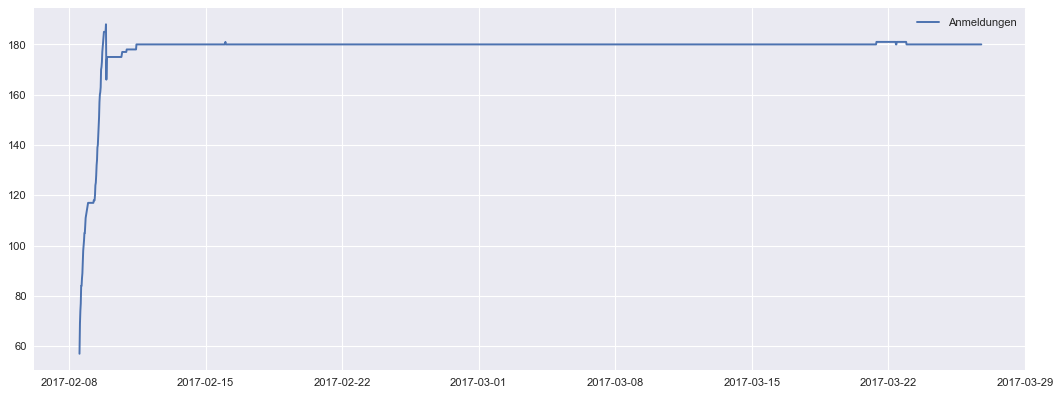

In [9]:
plot_index = [x[0] for x in anmeldungen_fr]
plot_graph = [x[1] for x in anmeldungen_fr]


fig = plt.figure(figsize=(16, 6), dpi=80)
line, = plt.plot(plot_index, plot_graph, label = 'Anmeldungen');
plt.legend(handles=[line])

Wenn man Daten in einem Diagramm vergleichen möchte, müssen diese denselben Index haben.

Die Indexe der Beispieldaten weichen leicht voneinander ab. Daher muss ich diese Daten an den gewünschten Index anpassen

Überführung der Daten in Dictionaries, damit diese leichter auf einen Index gebracht werden können

In [10]:
dict_anmeldung_fr = {k:v for k,v in anmeldungen_fr}
dict_anmeldung_sa = {k:v for k,v in anmeldungen_sa}
dict_warteliste_fr = {k:v for k,v in warteliste_fr}
dict_warteliste_sa = {k:v for k,v in warteliste_sa}

Da das Barcamp schon nach einer Woche komplett ausgebucht war, habe ich beschlossen, die Warteliste auch zu beobachten. 

Aufgrund der verspäteten Beobachtung fehlen mir die Daten der ersten Woche.



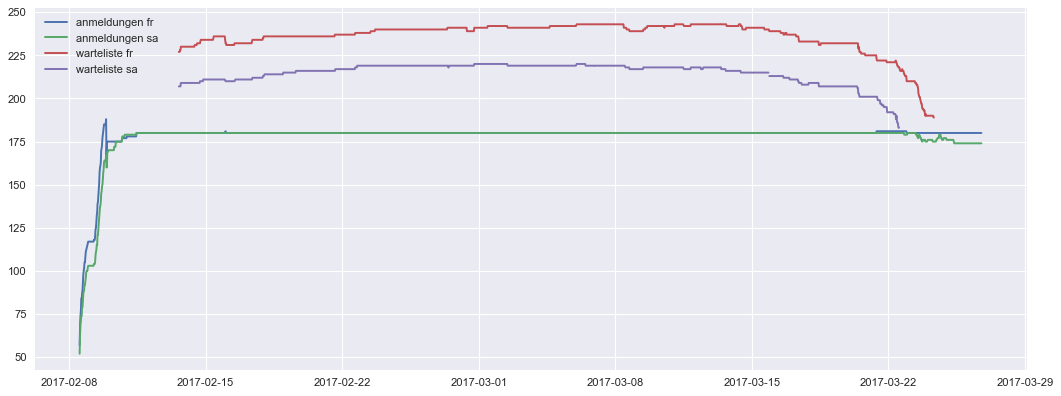

In [11]:
plot_index = [x[0] for x in anmeldungen_fr]
fig = plt.figure(figsize=(16, 6), dpi=80)
line_afr,  = plt.plot(plot_index, [dict_anmeldung_fr.get(x) for x in plot_index], label = 'anmeldungen fr');
line_asa,  = plt.plot(plot_index, [dict_anmeldung_sa.get(x) for x in plot_index], label = 'anmeldungen sa');
line_wfr,  = plt.plot(plot_index, [dict_warteliste_fr.get(x) + 180 if dict_warteliste_fr.get(x) else None  for x in plot_index], label = 'warteliste fr');
line_wsa,  = plt.plot(plot_index, [dict_warteliste_sa.get(x) + 180 if dict_warteliste_sa.get(x) else None for x in plot_index], label = 'warteliste sa');
plt.legend(handles=[line_afr,line_asa,line_wfr,line_wsa]);

## Teil 2 - Wer ist zuhause geblieben?

Das Barcam hat eine öffentliche Gästeliste. Es ist interessant, zu sehen, wer sich anmeldet und wer dann doch nicht gekommen ist.

Mit dem nachfolgendem Regulären Ausdruck werden Name und Firma in der Gästeliste gefunden.
Zur Erststellung nehme ich https://regex101.com/

Hinweis: Für die im Internet verfügbare Variante des Vortrags sind die Daten annonymisiert, siehe Teil 4

In [12]:
name_match = r'(?s)<div class=\"attendee\">.*?<div class=\"name\">(.*?)<br>.*?<div class=\"company\"(.*?)<br'



Analog zu Teil 1 lohnt es sich, die Aufgaben aufzuteilen. Ein Großteil der Funktionalität aus Teil 1 kann wiederverwendet werden. Es ist allerdings noch notwendig, eine Funktion zu schreiben, die alle Namen einer Gästeliste einer Datei findet. Diese Funktion wird dann später für alle Dateien aufgerufen.


In [13]:
def get_teilnehmer_from_guestlist(filename):
    # https://regex101.com/
    name_match = r'(?s)<div class=\"attendee\">.*?<div class=\"name\">(.*?)<br>.*?<div class=\"company\">(.*?)<br'    

    guestlist = [] 
    with open(filename , encoding='utf-8') as f1:
        for m in re.finditer(name_match, f1.read()):
            guestlist.append((m.group(1), m.group(2)))
    return guestlist


Finale Gästeliste

In [14]:
final_guestlist = get_teilnehmer_from_guestlist(get_filenames(_PATH, 'sa', typ='Anmeldung')[-1])

Anzahl der Gäste

In [15]:
len(final_guestlist)

166

Ausgabe der Gäste, sortiert

In [16]:
sorted(final_guestlist)

[('Achim Wolff', ''),
 ('Adelheid Arndt', ''),
 ('Alexander Radszun', 'PARK &amp; Bellheimer'),
 ('Anita Lochner', 'YMOS AG'),
 ('Anja Schüte', ''),
 ('Anna Thalbach', ''),
 ('Anne Bennent', 'curasan AG'),
 ('Annette Kreft', 'Solar-Fabrik'),
 ('Antje Hagen', ''),
 ('Antje Schmidt', ''),
 ('Astrid Bless', ''),
 ('Barbara Auer', 'RIM AG (ehemals RÜCKER IMMOBILIEN AKTIENGESELLSCHAFT)'),
 ('Beata Tyszkiewicz', 'AMP Biosimilars AG'),
 ('Ben Becker', ''),
 ('Bernd Tauber', ''),
 ('Billie Zöckler', 'm-u-t AG Messgeräte für Medizin- und Umwelttechnik'),
 ('Bodo Krämer', 'KROMI Logistik'),
 ('Bodo Wolf (Synchronsprecher)', 'EUROGRAPHICS AG'),
 ('Celino Bleiweiß', ''),
 ('Christian Berkel', ''),
 ('Christian Grashof', 'Constantin Medien'),
 ('Christian Kohlund', 'Bastfaserkontor Aktiengesellschaft'),
 ('Christian Steyer', 'Beiersdorf'),
 ('Christina Plate', 'Minaya Capital AG'),
 ('Christine Schorn', ''),
 ('Christoph Eichhorn', ''),
 ('Christoph M. Ohrt', 'Constantin Medien'),
 ('Claude-Oliver 

Jetzt können wir uns alle Dateien ansehen und nur auf Veränderungen in der Gästeliste achten.

Es wird für jede Datei festgehalten, ob ein Gast frisch hinzugekommen ist oder
von der Liste verschwunden ist.

In [17]:
prev_guestlist = []
anmeldungen = []
abmeldungen = []

f = FloatProgress(min=0, max=len(get_filenames(_PATH, 'fr', typ='Anmeldung')))
display(f)

for file in get_filenames(_PATH, 'fr', typ='Anmeldung'):
    
    f.value += 1
    
    filedt = get_datetime_from_filename(file)
    new_guestlist = get_teilnehmer_from_guestlist(file)
    
    for guest in new_guestlist:
        if not guest in prev_guestlist:
            anmeldungen.append((filedt, guest))
    
    for guest in prev_guestlist:
        if not guest in new_guestlist:
            abmeldungen.append((filedt, guest))
    
    prev_guestlist = new_guestlist


Widget Javascript not detected.  It may not be installed or enabled properly.


Beispiel: Zur Überprüfung die ersten zehn Anmeldungen anzeigen

In [18]:
anmeldungen[:10]

[(datetime.datetime(2017, 2, 8, 12, 56),
  ('David Bennent', 'VTG Aktiengesellschaft')),
 (datetime.datetime(2017, 2, 8, 12, 56),
  ('Klaus J. Behrendt', 'AMP Biosimilars AG')),
 (datetime.datetime(2017, 2, 8, 12, 56), ('Anita Lochner', 'YMOS AG')),
 (datetime.datetime(2017, 2, 8, 12, 56), ('Tina Engel', '')),
 (datetime.datetime(2017, 2, 8, 12, 56), ('Ulrike Beimpold', '')),
 (datetime.datetime(2017, 2, 8, 12, 56),
  ('Claude-Oliver Rudolph', 'InCity Immobilien AG')),
 (datetime.datetime(2017, 2, 8, 12, 56), ('Maren Kroymann', 'GRENKE')),
 (datetime.datetime(2017, 2, 8, 12, 56), ('Julia Biedermann', 'freenet AG')),
 (datetime.datetime(2017, 2, 8, 12, 56),
  ('Therese Lohner', 'Verallia Deutschland')),
 (datetime.datetime(2017, 2, 8, 12, 56), ('Katrin Sass', 'adesso AG'))]

Für die Bildschirmausgabe eine bessere Darstellung wählen

In [19]:
def formatiere_anmeldung(anmeldung):
    if anmeldung[1][1]:
      return '{} - {} - {}'.format(anmeldung[0],anmeldung[1][0],anmeldung[1][1])
    else:
      return '{} - {}'.format(anmeldung[0],anmeldung[1][0])

In [20]:
formatiere_anmeldung(anmeldungen[0])

'2017-02-08 12:56:00 - David Bennent - VTG Aktiengesellschaft'

Jetzt kann man alle Anmeldungen ansehen.

Genauso auch alle Abmeldungen

In [21]:
[formatiere_anmeldung(x) for x in abmeldungen]

['2017-02-09 17:00:00 - Ulrike Beimpold',
 '2017-02-09 22:00:00 - Barbara Freier - VERIANOS Real Estate Aktiengesellschaft (ehemals Real² Immobilien AG)',
 '2017-02-09 22:00:00 - Uwe Ochsenknecht - Diebold Nixdorf',
 '2017-02-09 22:00:00 - Ernst Kahler',
 '2017-02-09 22:00:00 - Micaëla Kreißler - KÖLN - DÜSSELDORFER Deutsche Rheinschiffahrt',
 '2017-02-09 22:00:00 - Ernst Meincke - Neuhof Textil-Holding Aktiengesellschaft',
 '2017-02-09 22:00:00 - Angelika Milster',
 '2017-02-09 22:00:00 - Jan Bereska',
 '2017-02-09 22:00:00 - Monika Hansen - HÖVELRAT Holding AG (ehemals nordaktienbank AG)',
 '2017-02-09 22:00:00 - Horst Kummeth - Netwatch AG (ehemals Artamia AG)',
 '2017-02-09 22:00:00 - Heinz Hoenig',
 '2017-02-09 22:00:00 - Toni Berger - HSBC US Buy-Out GmbH &amp; Co.KGaA',
 '2017-02-09 22:00:00 - Tobias Moretti - paragon',
 '2017-02-09 22:00:00 - Hildegard Alex - Lechwerke',
 '2017-02-09 22:00:00 - Rolf Herricht - Aleia Holding AG (ehemals Bebra Biogas Holding AG)',
 '2017-02-09 22

Wer hat sich mitten in der Nacht angemeldet?

In [22]:
import datetime
[formatiere_anmeldung(a) for a in anmeldungen if 0 < a[0].hour < 6  ]

['2017-02-16 01:30:00 - Rita Feldmeier - 4SC AG',
 '2017-02-16 01:30:00 - Gottfried John - UMT United Mobility Technology AG (vormals Leipziger Solarpark AG)',
 '2017-02-16 01:30:00 - Christine Neubauer - Neuhof Textil-Holding Aktiengesellschaft']

Welche Firmen waren besonders häufig da.

Was für Probleme könnten auf
treten?

In [23]:
from collections import Counter
d = Counter([x[1] for x in final_guestlist])

In [24]:
sorted([(k,v) for k,v in d.items() if k  and v > 1  ], key=lambda x:x[1], reverse = True)

[('freenet AG', 4),
 ('B.M.P. Pharma Trading AG', 4),
 ('AMP Biosimilars AG', 2),
 ('InCity Immobilien AG', 2),
 ('Verallia Deutschland', 2),
 ('adesso AG', 2),
 ('Dürr', 2),
 ('RIM AG (ehemals RÜCKER IMMOBILIEN AKTIENGESELLSCHAFT)', 2),
 ('PARK &amp; Bellheimer', 2),
 ('Constantin Medien', 2),
 ('DMG MORI', 2),
 ('SQS Software Quality Systems', 2),
 ('HSBC US Buy-Out GmbH &amp; Co.KGaA', 2),
 ('UMT United Mobility Technology AG (vormals Leipziger Solarpark AG)', 2),
 ('4SC AG', 2),
 ('Zalando', 2),
 ('Schnigge Wertpapierhandelsbank SE (zeitweise DKM Wertpapierhandelsbank AG)',
  2),
 ('bet-at-home.com AG', 2),
 ('transtec', 2),
 ('MyHammer Holding', 2)]

Hinweis: In der Realität ist die schreibweise des Firmennamens nicht immer gleich.

## Teil 3 - Der aufgedeckte "Skandal"

Schauen wir uns die Besucherliste für Freitag an.



In [25]:
final_guestlist = get_teilnehmer_from_guestlist(get_filenames(_PATH, 'fr', typ='Anmeldung')[-1])

In [27]:
[(e+1,x[0]) for e, x in enumerate(sorted(final_guestlist))]

[(1, 'Adelheid Arndt'),
 (2, 'Alexa Wiegandt'),
 (3, 'Alexander Radszun'),
 (4, 'Alfred Struwe'),
 (5, 'Amza Pellea'),
 (6, 'Angelika Milster'),
 (7, 'Anita Lochner'),
 (8, 'Anja Kruse'),
 (9, 'Anja Schüte'),
 (10, 'Anna Thalbach'),
 (11, 'Annemarie Marks-Rocke'),
 (12, 'Annette Kreft'),
 (13, 'Antje Hagen'),
 (14, 'Antje Schmidt'),
 (15, 'Barbara Freier'),
 (16, 'Barbara Rudnik'),
 (17, 'Barbara Schnitzler'),
 (18, 'Beata Tyszkiewicz'),
 (19, 'Ben Becker'),
 (20, 'Bernd Tauber'),
 (21, 'Birge Schade'),
 (22, 'Bodo Krämer'),
 (23, 'Brigitte Karner'),
 (24, 'Burghart Klaußner'),
 (25, 'Burkhard Driest'),
 (26, 'Christa Löser'),
 (27, 'Christian Berkel'),
 (28, 'Christian Grashof'),
 (29, 'Christian Steyer'),
 (30, 'Christine Neubauer'),
 (31, 'Christoph Eichhorn'),
 (32, 'Christoph M. Ohrt'),
 (33, 'Claude-Oliver Rudolph'),
 (34, 'Claudia Messner'),
 (35, 'Dean Reed'),
 (36, 'Detlef Gieß'),
 (37, 'Dieter Mann'),
 (38, 'Dietlinde Turban'),
 (39, 'Dietmar Bär'),
 (40, 'Dietmar Mössmer'),


Eigentlich hätte nur 180 Teilnehmer auf der Gästeliste sein sollen.

In der Seitenüberschrift steht das auch so drin.

Vielleicht sind Dubletten in der Liste?


In [28]:
len(set([g[0] for g in final_guestlist]))

192

Nein, es ist nur eine Person doppelt. 

Also zählen wir jetzt für jeden halbe Stunde die Liste und vergleichen das mit der Überschrift.

Da auf der Liste auch eine Anzahl von Teilnehmern angedruckt wird, die ihren Namen nicht im Internet sehen möchte,
nehmen wir diese Zahl mit dazu.

In [29]:
f = FloatProgress(min=0, max=len(get_filenames(_PATH, 'fr', typ='Anmeldung')))
display(f)
dict_anmeldung_fr_alt = {}
for file in get_filenames(_PATH, 'fr', typ='Anmeldung'):
    
    f.value += 1
    filedt = get_datetime_from_filename(file)
    new_guestlist = get_teilnehmer_from_guestlist(file)
    _, geheim = get_anmeldungen_from_file(file,typ='Geheim')

    dict_anmeldung_fr_alt[filedt] = len(new_guestlist) + geheim
    
    

Widget Javascript not detected.  It may not be installed or enabled properly.


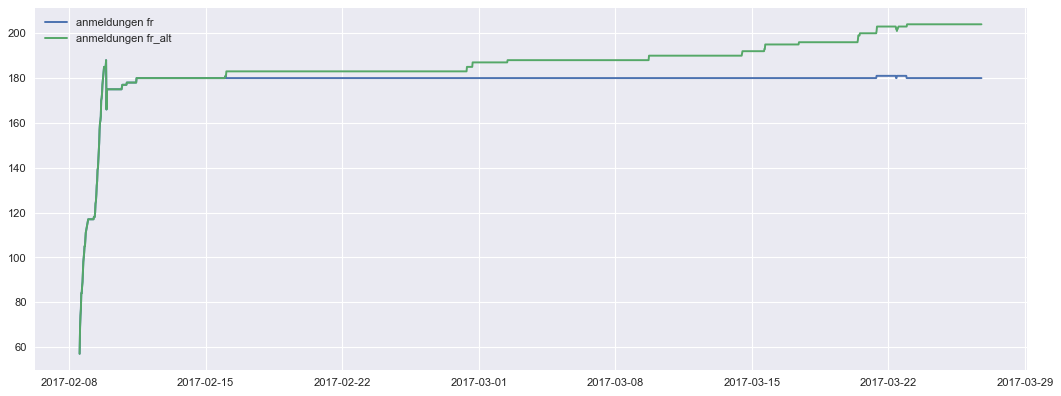

In [30]:
plot_index = [x[0] for x in anmeldungen_fr]
fig = plt.figure(figsize=(16, 6), dpi=80)
line_afr,  = plt.plot(plot_index, [dict_anmeldung_fr.get(x) for x in plot_index], label = 'anmeldungen fr');
line_afr2,  = plt.plot(plot_index, [dict_anmeldung_fr_alt.get(x) for x in plot_index], label = 'anmeldungen fr_alt');
plt.legend(handles=[line_afr,line_afr2]);

# Bonus - Teil 4 - Daten anonymisieren
    
Bevor man Daten ins Internet stellt, sollte man sich gut überlegen, ob man damit nicht die Persönlichkeitsrechte anderer verletzt. Im Zweifelsfall kann man die Daten anonymisieren. 

Im nachfolgendem Beispiel ersetze ich die Namen von Personen und Firmen durch Namen aus Wikipedia.

Die Dateien werden in einen Unterordner **fakes** kopiert.
Die Unterverzeichnisse **FR**,**SA**,**W_FR**,**W_SA** bitte selbst anlegen



Alle Anmeldungen sammeln, damit ich ein Ersetzungsverzeichnung anlegen kann und weiss, wieviele Ersatznamen ich benötige.

In [48]:
alle_anmeldungen = set()

f = FloatProgress(min=0, max=len(get_filenames(_PATH, 'fr', typ='Anmeldung'))+
                             len(get_filenames(_PATH, 'sa', typ='Anmeldung')))
display(f)

for file in list(get_filenames(_PATH, 'fr', typ='Anmeldung'))+list(get_filenames(_PATH, 'sa', typ='Anmeldung')):
    f.value += 1
    new_guestlist = get_teilnehmer_from_guestlist(file)
    alle_anmeldungen = alle_anmeldungen.union(set(new_guestlist))


Widget Javascript not detected.  It may not be installed or enabled properly.


In [49]:
len(alle_anmeldungen)

373

In [50]:
alle_anmeldungen

{('Achim Wolff', ''),
 ('Adelheid Arndt', ''),
 ('Adelheid Arndt', 'United Labels'),
 ('Adriana Altaras', 'Noratis AG'),
 ('Alexa Wiegandt', 'GIEAG Immobilien AG'),
 ('Alexa Wiegandt', 'PARK &amp; Bellheimer'),
 ('Alexander Radszun', 'HWA AG'),
 ('Alexander Radszun', 'PARK &amp; Bellheimer'),
 ('Alfred Struwe', 'XING'),
 ('Amza Pellea', 'Mensch und Maschine Software SE'),
 ('Andrea L’Arronge', 'Noratis AG'),
 ('André Heller',
  'Münchener Rückversicherungs-Gesellschaft Aktiengesellschaft in München'),
 ('Angelika Milster', ''),
 ('Anita Lochner', 'YMOS AG'),
 ('Anja Kruse', 'Convertis AG (ehemals Energie-Effizienz Beteiligungs AG)'),
 ('Anja Schüte', ''),
 ('Anna Thalbach', ''),
 ('Annamirl Bierbichler', 'PULSION'),
 ('Anne Bennent', 'curasan AG'),
 ('Annemarie Marks-Rocke',
  'Vestcorp AG (vormals TFG Capital AG Unternehmensbeteiligungsgesellschaft)'),
 ('Annette Kreft', 'Solar-Fabrik'),
 ('Antje Hagen', ''),
 ('Antje Schmidt', ''),
 ('Astrid Bless', ''),
 ('Barbara Auer', 'RIM AG (eh

Mit "requests" eine Unternehmensliste aus der Wikipedia holen und die Namen aus der Liste übernehmen.

In [51]:
import requests

In [52]:
r = requests.get(r'https://de.wikipedia.org/wiki/Liste_der_b%C3%B6rsennotierten_deutschen_Unternehmen')

In [53]:
from random import shuffle
pattern = r'<li>(.*?)</li>'
pattern2 = r'<a href.*?>(.*?)</a>'
companies = []
for m in re.finditer(pattern, r.text):
    m2 = re.search(pattern2, m.group(1))
    if m2:
        companies.append(m2.group(1))    
    else:
        companies.append(m.group(1))
shuffle(companies);    


Mit "requests" eine Schauspielerliste aus der Wikipedia holen und die Namen aus der Liste übernehmen.

In [54]:
r = requests.get(r'https://de.wikipedia.org/wiki/Liste_bekannter_Darsteller_des_deutschsprachigen_Films')

In [55]:
actors = []
pattern = r'<a href=\"/wiki/(.*?)\" title=\"(.*?)\">(.*?)</a'
for m in re.finditer(pattern, r.text):
    if str(m.group(2)) == str(m.group(3)):
        if not 'Liste' in m.group(3):
            actors.append(m.group(3))
    
actors = sorted(actors[-900:-500:])    
shuffle(actors)


In [56]:
len(actors)

400

Jeweils für Namen und Firma erstelle ich jetzt ein Dictionary

In [57]:
fake_person = {p:a for p,a in zip(list(set([a[0] for a in alle_anmeldungen])),actors)}
fake_company = {c:n for c,n in zip(list(set([a[1] for a in alle_anmeldungen if a[1]])),companies)}

Der nachfolgende Code erstellt eine simple HTML Fälschung, mit der der obige Code funktioniert

In [58]:
fake_html = """
<html><body>Fake Barcamp HTML Code
<p>{teilnehmer}      {geheim}
<p>
{tnliste}
</body>
</html>
"""
fake_div = """
<div class="attendee">
  <div class="name">{name}<br></div>
  <div class="company">{company}<br></div>
</div class="attendee">  

"""

def fake_guestlist(filename):
    fake_file = filename.replace('barcamp','barcamp\\fakes')
    print(filename)
    
    _, teilnehmer = get_anmeldungen_from_file(filename,typ='Anmeldung')
    teilnehmer = 'Es gibt bereits {} Teilnehmer.'.format(teilnehmer)
    _, geheim = get_anmeldungen_from_file(filename,typ='Geheim')
    if geheim:
       geheim = '{} Teilnehmer möchten nicht auf dieser Liste erscheinen.'.format(geheim)
    else:
       geheim = ''

    tn2 = [] 
    for tn in get_teilnehmer_from_guestlist(filename):
        tn2.append(fake_div.format(name=fake_person[tn[0]],
                                  company=fake_company.get(tn[1],'')))
            
    tnliste = '\n'.join(tn2)
    with open(fake_file, 'w', encoding='utf-8') as w1:
        w1.write(fake_html.format(teilnehmer=teilnehmer,
                                 geheim=geheim,
                                 tnliste = tnliste))
    return(teilnehmer, geheim)

Fake Datei erstellen


In [59]:
fake_guestlist(get_filenames(_PATH, 'sa', typ='Anmeldung')[0]);

..\barcamp\SA\sa_2017-02-08_12-56.html


Testen, ob der Fake auch funktioniert

In [60]:
get_teilnehmer_from_guestlist(r'fakes\SA\sa_2017-02-08_12-56.html')
get_anmeldungen_from_file(r'fakes\SA\sa_2017-02-08_12-56.html',typ='Geheim')

(datetime.datetime(2017, 2, 8, 12, 56), 3)

Alle Anmeldeseiten faken

In [61]:
f = FloatProgress(min=0, max=len(get_filenames(_PATH, 'fr', typ='Anmeldung'))+
                             len(get_filenames(_PATH, 'sa', typ='Anmeldung')))
display(f)

for file in list(get_filenames(_PATH, 'fr', typ='Anmeldung'))+list(get_filenames(_PATH, 'sa', typ='Anmeldung')):
    f.value += 1
    fake_guestlist(file)
    
;    

Widget Javascript not detected.  It may not be installed or enabled properly.


..\barcamp\FR\fr_2017-02-08_12-56.html
..\barcamp\FR\fr_2017-02-08_12-59.html
..\barcamp\FR\fr_2017-02-08_13-00.html
..\barcamp\FR\fr_2017-02-08_13-30.html
..\barcamp\FR\fr_2017-02-08_14-00.html
..\barcamp\FR\fr_2017-02-08_14-30.html
..\barcamp\FR\fr_2017-02-08_15-00.html
..\barcamp\FR\fr_2017-02-08_15-30.html
..\barcamp\FR\fr_2017-02-08_16-00.html
..\barcamp\FR\fr_2017-02-08_16-30.html
..\barcamp\FR\fr_2017-02-08_17-30.html
..\barcamp\FR\fr_2017-02-08_18-00.html
..\barcamp\FR\fr_2017-02-08_18-30.html
..\barcamp\FR\fr_2017-02-08_19-00.html
..\barcamp\FR\fr_2017-02-08_19-30.html
..\barcamp\FR\fr_2017-02-08_20-00.html
..\barcamp\FR\fr_2017-02-08_20-30.html
..\barcamp\FR\fr_2017-02-08_21-00.html
..\barcamp\FR\fr_2017-02-08_21-30.html
..\barcamp\FR\fr_2017-02-08_22-00.html
..\barcamp\FR\fr_2017-02-08_22-30.html
..\barcamp\FR\fr_2017-02-08_23-00.html
..\barcamp\FR\fr_2017-02-08_23-30.html
..\barcamp\FR\fr_2017-02-09_00-30.html
..\barcamp\FR\fr_2017-02-09_01-00.html
..\barcamp\FR\fr_2017-02-

..\barcamp\FR\fr_2017-02-13_11-00.html
..\barcamp\FR\fr_2017-02-13_11-30.html
..\barcamp\FR\fr_2017-02-13_12-30.html
..\barcamp\FR\fr_2017-02-13_13-00.html
..\barcamp\FR\fr_2017-02-13_13-30.html
..\barcamp\FR\fr_2017-02-13_14-00.html
..\barcamp\FR\fr_2017-02-13_14-30.html
..\barcamp\FR\fr_2017-02-13_15-00.html
..\barcamp\FR\fr_2017-02-13_15-30.html
..\barcamp\FR\fr_2017-02-13_16-00.html
..\barcamp\FR\fr_2017-02-13_16-30.html
..\barcamp\FR\fr_2017-02-13_17-00.html
..\barcamp\FR\fr_2017-02-13_17-30.html
..\barcamp\FR\fr_2017-02-13_18-00.html
..\barcamp\FR\fr_2017-02-13_18-30.html
..\barcamp\FR\fr_2017-02-13_19-00.html
..\barcamp\FR\fr_2017-02-13_19-30.html
..\barcamp\FR\fr_2017-02-13_20-00.html
..\barcamp\FR\fr_2017-02-13_20-30.html
..\barcamp\FR\fr_2017-02-13_21-00.html
..\barcamp\FR\fr_2017-02-13_21-30.html
..\barcamp\FR\fr_2017-02-13_22-00.html
..\barcamp\FR\fr_2017-02-13_22-30.html
..\barcamp\FR\fr_2017-02-13_23-00.html
..\barcamp\FR\fr_2017-02-13_23-30.html
..\barcamp\FR\fr_2017-02-

..\barcamp\FR\fr_2017-02-18_07-30.html
..\barcamp\FR\fr_2017-02-18_08-00.html
..\barcamp\FR\fr_2017-02-18_08-30.html
..\barcamp\FR\fr_2017-02-18_09-00.html
..\barcamp\FR\fr_2017-02-18_09-30.html
..\barcamp\FR\fr_2017-02-18_10-00.html
..\barcamp\FR\fr_2017-02-18_10-30.html
..\barcamp\FR\fr_2017-02-18_11-00.html
..\barcamp\FR\fr_2017-02-18_11-30.html
..\barcamp\FR\fr_2017-02-18_12-30.html
..\barcamp\FR\fr_2017-02-18_13-00.html
..\barcamp\FR\fr_2017-02-18_13-30.html
..\barcamp\FR\fr_2017-02-18_14-00.html
..\barcamp\FR\fr_2017-02-18_14-30.html
..\barcamp\FR\fr_2017-02-18_15-00.html
..\barcamp\FR\fr_2017-02-18_15-30.html
..\barcamp\FR\fr_2017-02-18_16-00.html
..\barcamp\FR\fr_2017-02-18_16-30.html
..\barcamp\FR\fr_2017-02-18_17-00.html
..\barcamp\FR\fr_2017-02-18_17-30.html
..\barcamp\FR\fr_2017-02-18_18-00.html
..\barcamp\FR\fr_2017-02-18_18-30.html
..\barcamp\FR\fr_2017-02-18_19-00.html
..\barcamp\FR\fr_2017-02-18_19-30.html
..\barcamp\FR\fr_2017-02-18_20-00.html
..\barcamp\FR\fr_2017-02-

..\barcamp\FR\fr_2017-02-22_22-00.html
..\barcamp\FR\fr_2017-02-22_22-30.html
..\barcamp\FR\fr_2017-02-22_23-00.html
..\barcamp\FR\fr_2017-02-22_23-30.html
..\barcamp\FR\fr_2017-02-23_00-30.html
..\barcamp\FR\fr_2017-02-23_01-00.html
..\barcamp\FR\fr_2017-02-23_01-30.html
..\barcamp\FR\fr_2017-02-23_02-00.html
..\barcamp\FR\fr_2017-02-23_02-30.html
..\barcamp\FR\fr_2017-02-23_03-00.html
..\barcamp\FR\fr_2017-02-23_03-30.html
..\barcamp\FR\fr_2017-02-23_04-00.html
..\barcamp\FR\fr_2017-02-23_04-30.html
..\barcamp\FR\fr_2017-02-23_05-00.html
..\barcamp\FR\fr_2017-02-23_05-30.html
..\barcamp\FR\fr_2017-02-23_06-00.html
..\barcamp\FR\fr_2017-02-23_06-30.html
..\barcamp\FR\fr_2017-02-23_07-00.html
..\barcamp\FR\fr_2017-02-23_07-30.html
..\barcamp\FR\fr_2017-02-23_08-00.html
..\barcamp\FR\fr_2017-02-23_08-30.html
..\barcamp\FR\fr_2017-02-23_09-00.html
..\barcamp\FR\fr_2017-02-23_09-30.html
..\barcamp\FR\fr_2017-02-23_10-00.html
..\barcamp\FR\fr_2017-02-23_10-30.html
..\barcamp\FR\fr_2017-02-

..\barcamp\FR\fr_2017-02-27_16-30.html
..\barcamp\FR\fr_2017-02-27_17-00.html
..\barcamp\FR\fr_2017-02-27_17-30.html
..\barcamp\FR\fr_2017-02-27_18-00.html
..\barcamp\FR\fr_2017-02-27_18-30.html
..\barcamp\FR\fr_2017-02-27_19-00.html
..\barcamp\FR\fr_2017-02-27_19-30.html
..\barcamp\FR\fr_2017-02-27_20-00.html
..\barcamp\FR\fr_2017-02-27_20-30.html
..\barcamp\FR\fr_2017-02-27_21-00.html
..\barcamp\FR\fr_2017-02-27_21-30.html
..\barcamp\FR\fr_2017-02-27_22-00.html
..\barcamp\FR\fr_2017-02-27_22-30.html
..\barcamp\FR\fr_2017-02-27_23-00.html
..\barcamp\FR\fr_2017-02-27_23-30.html
..\barcamp\FR\fr_2017-02-28_00-30.html
..\barcamp\FR\fr_2017-02-28_01-00.html
..\barcamp\FR\fr_2017-02-28_01-30.html
..\barcamp\FR\fr_2017-02-28_02-00.html
..\barcamp\FR\fr_2017-02-28_02-30.html
..\barcamp\FR\fr_2017-02-28_03-00.html
..\barcamp\FR\fr_2017-02-28_03-30.html
..\barcamp\FR\fr_2017-02-28_04-00.html
..\barcamp\FR\fr_2017-02-28_04-30.html
..\barcamp\FR\fr_2017-02-28_05-00.html
..\barcamp\FR\fr_2017-02-

..\barcamp\FR\fr_2017-03-04_09-00.html
..\barcamp\FR\fr_2017-03-04_09-30.html
..\barcamp\FR\fr_2017-03-04_10-00.html
..\barcamp\FR\fr_2017-03-04_10-30.html
..\barcamp\FR\fr_2017-03-04_11-00.html
..\barcamp\FR\fr_2017-03-04_11-30.html
..\barcamp\FR\fr_2017-03-04_12-30.html
..\barcamp\FR\fr_2017-03-04_13-00.html
..\barcamp\FR\fr_2017-03-04_13-30.html
..\barcamp\FR\fr_2017-03-04_14-00.html
..\barcamp\FR\fr_2017-03-04_14-30.html
..\barcamp\FR\fr_2017-03-04_15-00.html
..\barcamp\FR\fr_2017-03-04_15-30.html
..\barcamp\FR\fr_2017-03-04_16-00.html
..\barcamp\FR\fr_2017-03-04_16-30.html
..\barcamp\FR\fr_2017-03-04_17-00.html
..\barcamp\FR\fr_2017-03-04_17-30.html
..\barcamp\FR\fr_2017-03-04_18-00.html
..\barcamp\FR\fr_2017-03-04_18-30.html
..\barcamp\FR\fr_2017-03-04_19-00.html
..\barcamp\FR\fr_2017-03-04_19-30.html
..\barcamp\FR\fr_2017-03-04_20-00.html
..\barcamp\FR\fr_2017-03-04_20-30.html
..\barcamp\FR\fr_2017-03-04_21-00.html
..\barcamp\FR\fr_2017-03-04_21-30.html
..\barcamp\FR\fr_2017-03-

..\barcamp\FR\fr_2017-03-09_01-30.html
..\barcamp\FR\fr_2017-03-09_02-00.html
..\barcamp\FR\fr_2017-03-09_02-30.html
..\barcamp\FR\fr_2017-03-09_03-00.html
..\barcamp\FR\fr_2017-03-09_03-30.html
..\barcamp\FR\fr_2017-03-09_04-00.html
..\barcamp\FR\fr_2017-03-09_04-30.html
..\barcamp\FR\fr_2017-03-09_05-00.html
..\barcamp\FR\fr_2017-03-09_05-30.html
..\barcamp\FR\fr_2017-03-09_06-00.html
..\barcamp\FR\fr_2017-03-09_06-30.html
..\barcamp\FR\fr_2017-03-09_07-00.html
..\barcamp\FR\fr_2017-03-09_07-30.html
..\barcamp\FR\fr_2017-03-09_08-00.html
..\barcamp\FR\fr_2017-03-09_08-30.html
..\barcamp\FR\fr_2017-03-09_09-00.html
..\barcamp\FR\fr_2017-03-09_09-30.html
..\barcamp\FR\fr_2017-03-09_10-00.html
..\barcamp\FR\fr_2017-03-09_10-30.html
..\barcamp\FR\fr_2017-03-09_11-00.html
..\barcamp\FR\fr_2017-03-09_11-30.html
..\barcamp\FR\fr_2017-03-09_12-30.html
..\barcamp\FR\fr_2017-03-09_13-00.html
..\barcamp\FR\fr_2017-03-09_13-30.html
..\barcamp\FR\fr_2017-03-09_14-00.html
..\barcamp\FR\fr_2017-03-

..\barcamp\FR\fr_2017-03-13_18-00.html
..\barcamp\FR\fr_2017-03-13_18-30.html
..\barcamp\FR\fr_2017-03-13_19-00.html
..\barcamp\FR\fr_2017-03-13_19-30.html
..\barcamp\FR\fr_2017-03-13_20-00.html
..\barcamp\FR\fr_2017-03-13_20-30.html
..\barcamp\FR\fr_2017-03-13_21-00.html
..\barcamp\FR\fr_2017-03-13_21-30.html
..\barcamp\FR\fr_2017-03-13_22-00.html
..\barcamp\FR\fr_2017-03-13_22-30.html
..\barcamp\FR\fr_2017-03-13_23-00.html
..\barcamp\FR\fr_2017-03-13_23-30.html
..\barcamp\FR\fr_2017-03-14_00-30.html
..\barcamp\FR\fr_2017-03-14_01-00.html
..\barcamp\FR\fr_2017-03-14_01-30.html
..\barcamp\FR\fr_2017-03-14_02-00.html
..\barcamp\FR\fr_2017-03-14_02-30.html
..\barcamp\FR\fr_2017-03-14_03-00.html
..\barcamp\FR\fr_2017-03-14_03-30.html
..\barcamp\FR\fr_2017-03-14_04-00.html
..\barcamp\FR\fr_2017-03-14_04-30.html
..\barcamp\FR\fr_2017-03-14_05-00.html
..\barcamp\FR\fr_2017-03-14_05-30.html
..\barcamp\FR\fr_2017-03-14_06-00.html
..\barcamp\FR\fr_2017-03-14_06-30.html
..\barcamp\FR\fr_2017-03-

..\barcamp\FR\fr_2017-03-18_14-30.html
..\barcamp\FR\fr_2017-03-18_15-00.html
..\barcamp\FR\fr_2017-03-18_15-30.html
..\barcamp\FR\fr_2017-03-18_16-00.html
..\barcamp\FR\fr_2017-03-18_16-30.html
..\barcamp\FR\fr_2017-03-18_17-00.html
..\barcamp\FR\fr_2017-03-18_17-30.html
..\barcamp\FR\fr_2017-03-18_18-00.html
..\barcamp\FR\fr_2017-03-18_18-30.html
..\barcamp\FR\fr_2017-03-18_19-00.html
..\barcamp\FR\fr_2017-03-18_19-30.html
..\barcamp\FR\fr_2017-03-18_20-00.html
..\barcamp\FR\fr_2017-03-18_20-30.html
..\barcamp\FR\fr_2017-03-18_21-00.html
..\barcamp\FR\fr_2017-03-18_21-30.html
..\barcamp\FR\fr_2017-03-18_22-00.html
..\barcamp\FR\fr_2017-03-18_22-30.html
..\barcamp\FR\fr_2017-03-18_23-00.html
..\barcamp\FR\fr_2017-03-18_23-30.html
..\barcamp\FR\fr_2017-03-19_00-30.html
..\barcamp\FR\fr_2017-03-19_01-00.html
..\barcamp\FR\fr_2017-03-19_01-30.html
..\barcamp\FR\fr_2017-03-19_02-00.html
..\barcamp\FR\fr_2017-03-19_02-30.html
..\barcamp\FR\fr_2017-03-19_03-00.html
..\barcamp\FR\fr_2017-03-

..\barcamp\FR\fr_2017-03-23_15-00.html
..\barcamp\FR\fr_2017-03-23_15-30.html
..\barcamp\FR\fr_2017-03-23_16-00.html
..\barcamp\FR\fr_2017-03-23_16-30.html
..\barcamp\FR\fr_2017-03-23_17-00.html
..\barcamp\FR\fr_2017-03-23_17-30.html
..\barcamp\FR\fr_2017-03-23_18-00.html
..\barcamp\FR\fr_2017-03-23_18-30.html
..\barcamp\FR\fr_2017-03-23_19-00.html
..\barcamp\FR\fr_2017-03-23_19-30.html
..\barcamp\FR\fr_2017-03-23_20-00.html
..\barcamp\FR\fr_2017-03-23_20-30.html
..\barcamp\FR\fr_2017-03-23_21-00.html
..\barcamp\FR\fr_2017-03-23_21-30.html
..\barcamp\FR\fr_2017-03-23_22-00.html
..\barcamp\FR\fr_2017-03-23_22-30.html
..\barcamp\FR\fr_2017-03-23_23-00.html
..\barcamp\FR\fr_2017-03-23_23-30.html
..\barcamp\FR\fr_2017-03-24_00-30.html
..\barcamp\FR\fr_2017-03-24_01-00.html
..\barcamp\FR\fr_2017-03-24_01-30.html
..\barcamp\FR\fr_2017-03-24_02-00.html
..\barcamp\FR\fr_2017-03-24_02-30.html
..\barcamp\FR\fr_2017-03-24_03-00.html
..\barcamp\FR\fr_2017-03-24_03-30.html
..\barcamp\FR\fr_2017-03-

..\barcamp\SA\sa_2017-02-10_06-30.html
..\barcamp\SA\sa_2017-02-10_07-00.html
..\barcamp\SA\sa_2017-02-10_07-30.html
..\barcamp\SA\sa_2017-02-10_08-00.html
..\barcamp\SA\sa_2017-02-10_08-30.html
..\barcamp\SA\sa_2017-02-10_09-00.html
..\barcamp\SA\sa_2017-02-10_09-30.html
..\barcamp\SA\sa_2017-02-10_10-00.html
..\barcamp\SA\sa_2017-02-10_10-30.html
..\barcamp\SA\sa_2017-02-10_11-00.html
..\barcamp\SA\sa_2017-02-10_11-30.html
..\barcamp\SA\sa_2017-02-10_12-30.html
..\barcamp\SA\sa_2017-02-10_13-00.html
..\barcamp\SA\sa_2017-02-10_13-30.html
..\barcamp\SA\sa_2017-02-10_14-00.html
..\barcamp\SA\sa_2017-02-10_14-30.html
..\barcamp\SA\sa_2017-02-10_15-00.html
..\barcamp\SA\sa_2017-02-10_15-30.html
..\barcamp\SA\sa_2017-02-10_16-00.html
..\barcamp\SA\sa_2017-02-10_16-30.html
..\barcamp\SA\sa_2017-02-10_17-00.html
..\barcamp\SA\sa_2017-02-10_17-30.html
..\barcamp\SA\sa_2017-02-10_18-00.html
..\barcamp\SA\sa_2017-02-10_18-30.html
..\barcamp\SA\sa_2017-02-10_19-00.html
..\barcamp\SA\sa_2017-02-

..\barcamp\SA\sa_2017-02-15_03-00.html
..\barcamp\SA\sa_2017-02-15_03-30.html
..\barcamp\SA\sa_2017-02-15_04-00.html
..\barcamp\SA\sa_2017-02-15_04-30.html
..\barcamp\SA\sa_2017-02-15_05-00.html
..\barcamp\SA\sa_2017-02-15_05-30.html
..\barcamp\SA\sa_2017-02-15_06-00.html
..\barcamp\SA\sa_2017-02-15_06-30.html
..\barcamp\SA\sa_2017-02-15_07-00.html
..\barcamp\SA\sa_2017-02-15_07-30.html
..\barcamp\SA\sa_2017-02-15_08-00.html
..\barcamp\SA\sa_2017-02-15_08-30.html
..\barcamp\SA\sa_2017-02-15_09-00.html
..\barcamp\SA\sa_2017-02-15_09-30.html
..\barcamp\SA\sa_2017-02-15_10-00.html
..\barcamp\SA\sa_2017-02-15_10-30.html
..\barcamp\SA\sa_2017-02-15_11-00.html
..\barcamp\SA\sa_2017-02-15_11-30.html
..\barcamp\SA\sa_2017-02-15_12-30.html
..\barcamp\SA\sa_2017-02-15_13-00.html
..\barcamp\SA\sa_2017-02-15_13-30.html
..\barcamp\SA\sa_2017-02-15_14-00.html
..\barcamp\SA\sa_2017-02-15_14-30.html
..\barcamp\SA\sa_2017-02-15_15-00.html
..\barcamp\SA\sa_2017-02-15_15-30.html
..\barcamp\SA\sa_2017-02-

..\barcamp\SA\sa_2017-02-19_22-30.html
..\barcamp\SA\sa_2017-02-19_23-00.html
..\barcamp\SA\sa_2017-02-19_23-30.html
..\barcamp\SA\sa_2017-02-20_00-30.html
..\barcamp\SA\sa_2017-02-20_01-00.html
..\barcamp\SA\sa_2017-02-20_01-30.html
..\barcamp\SA\sa_2017-02-20_02-00.html
..\barcamp\SA\sa_2017-02-20_02-30.html
..\barcamp\SA\sa_2017-02-20_03-00.html
..\barcamp\SA\sa_2017-02-20_03-30.html
..\barcamp\SA\sa_2017-02-20_04-00.html
..\barcamp\SA\sa_2017-02-20_04-30.html
..\barcamp\SA\sa_2017-02-20_05-00.html
..\barcamp\SA\sa_2017-02-20_05-30.html
..\barcamp\SA\sa_2017-02-20_06-00.html
..\barcamp\SA\sa_2017-02-20_06-30.html
..\barcamp\SA\sa_2017-02-20_07-00.html
..\barcamp\SA\sa_2017-02-20_07-30.html
..\barcamp\SA\sa_2017-02-20_08-00.html
..\barcamp\SA\sa_2017-02-20_08-30.html
..\barcamp\SA\sa_2017-02-20_09-00.html
..\barcamp\SA\sa_2017-02-20_09-30.html
..\barcamp\SA\sa_2017-02-20_10-00.html
..\barcamp\SA\sa_2017-02-20_10-30.html
..\barcamp\SA\sa_2017-02-20_11-00.html
..\barcamp\SA\sa_2017-02-

..\barcamp\SA\sa_2017-02-24_23-30.html
..\barcamp\SA\sa_2017-02-25_00-30.html
..\barcamp\SA\sa_2017-02-25_01-00.html
..\barcamp\SA\sa_2017-02-25_01-30.html
..\barcamp\SA\sa_2017-02-25_02-00.html
..\barcamp\SA\sa_2017-02-25_02-30.html
..\barcamp\SA\sa_2017-02-25_03-00.html
..\barcamp\SA\sa_2017-02-25_03-30.html
..\barcamp\SA\sa_2017-02-25_04-00.html
..\barcamp\SA\sa_2017-02-25_04-30.html
..\barcamp\SA\sa_2017-02-25_05-00.html
..\barcamp\SA\sa_2017-02-25_05-30.html
..\barcamp\SA\sa_2017-02-25_06-00.html
..\barcamp\SA\sa_2017-02-25_06-30.html
..\barcamp\SA\sa_2017-02-25_07-00.html
..\barcamp\SA\sa_2017-02-25_07-30.html
..\barcamp\SA\sa_2017-02-25_08-00.html
..\barcamp\SA\sa_2017-02-25_08-30.html
..\barcamp\SA\sa_2017-02-25_09-00.html
..\barcamp\SA\sa_2017-02-25_09-30.html
..\barcamp\SA\sa_2017-02-25_10-00.html
..\barcamp\SA\sa_2017-02-25_10-30.html
..\barcamp\SA\sa_2017-02-25_11-00.html
..\barcamp\SA\sa_2017-02-25_11-30.html
..\barcamp\SA\sa_2017-02-25_12-30.html
..\barcamp\SA\sa_2017-02-

..\barcamp\SA\sa_2017-03-01_20-30.html
..\barcamp\SA\sa_2017-03-01_21-00.html
..\barcamp\SA\sa_2017-03-01_21-30.html
..\barcamp\SA\sa_2017-03-01_22-00.html
..\barcamp\SA\sa_2017-03-01_22-30.html
..\barcamp\SA\sa_2017-03-01_23-00.html
..\barcamp\SA\sa_2017-03-01_23-30.html
..\barcamp\SA\sa_2017-03-02_00-30.html
..\barcamp\SA\sa_2017-03-02_01-00.html
..\barcamp\SA\sa_2017-03-02_01-30.html
..\barcamp\SA\sa_2017-03-02_02-00.html
..\barcamp\SA\sa_2017-03-02_02-30.html
..\barcamp\SA\sa_2017-03-02_03-00.html
..\barcamp\SA\sa_2017-03-02_03-30.html
..\barcamp\SA\sa_2017-03-02_04-00.html
..\barcamp\SA\sa_2017-03-02_04-30.html
..\barcamp\SA\sa_2017-03-02_05-00.html
..\barcamp\SA\sa_2017-03-02_05-30.html
..\barcamp\SA\sa_2017-03-02_06-00.html
..\barcamp\SA\sa_2017-03-02_06-30.html
..\barcamp\SA\sa_2017-03-02_07-00.html
..\barcamp\SA\sa_2017-03-02_07-30.html
..\barcamp\SA\sa_2017-03-02_08-00.html
..\barcamp\SA\sa_2017-03-02_08-30.html
..\barcamp\SA\sa_2017-03-02_09-00.html
..\barcamp\SA\sa_2017-03-

..\barcamp\SA\sa_2017-03-06_14-30.html
..\barcamp\SA\sa_2017-03-06_15-00.html
..\barcamp\SA\sa_2017-03-06_15-30.html
..\barcamp\SA\sa_2017-03-06_16-00.html
..\barcamp\SA\sa_2017-03-06_16-30.html
..\barcamp\SA\sa_2017-03-06_17-00.html
..\barcamp\SA\sa_2017-03-06_17-30.html
..\barcamp\SA\sa_2017-03-06_18-00.html
..\barcamp\SA\sa_2017-03-06_18-30.html
..\barcamp\SA\sa_2017-03-06_19-00.html
..\barcamp\SA\sa_2017-03-06_19-30.html
..\barcamp\SA\sa_2017-03-06_20-00.html
..\barcamp\SA\sa_2017-03-06_20-30.html
..\barcamp\SA\sa_2017-03-06_21-00.html
..\barcamp\SA\sa_2017-03-06_21-30.html
..\barcamp\SA\sa_2017-03-06_22-00.html
..\barcamp\SA\sa_2017-03-06_22-30.html
..\barcamp\SA\sa_2017-03-06_23-00.html
..\barcamp\SA\sa_2017-03-06_23-30.html
..\barcamp\SA\sa_2017-03-07_00-30.html
..\barcamp\SA\sa_2017-03-07_01-00.html
..\barcamp\SA\sa_2017-03-07_01-30.html
..\barcamp\SA\sa_2017-03-07_02-00.html
..\barcamp\SA\sa_2017-03-07_02-30.html
..\barcamp\SA\sa_2017-03-07_03-00.html
..\barcamp\SA\sa_2017-03-

..\barcamp\SA\sa_2017-03-11_12-30.html
..\barcamp\SA\sa_2017-03-11_13-00.html
..\barcamp\SA\sa_2017-03-11_13-30.html
..\barcamp\SA\sa_2017-03-11_14-00.html
..\barcamp\SA\sa_2017-03-11_14-30.html
..\barcamp\SA\sa_2017-03-11_15-00.html
..\barcamp\SA\sa_2017-03-11_15-30.html
..\barcamp\SA\sa_2017-03-11_16-00.html
..\barcamp\SA\sa_2017-03-11_16-30.html
..\barcamp\SA\sa_2017-03-11_17-00.html
..\barcamp\SA\sa_2017-03-11_17-30.html
..\barcamp\SA\sa_2017-03-11_18-00.html
..\barcamp\SA\sa_2017-03-11_18-30.html
..\barcamp\SA\sa_2017-03-11_19-00.html
..\barcamp\SA\sa_2017-03-11_19-30.html
..\barcamp\SA\sa_2017-03-11_20-00.html
..\barcamp\SA\sa_2017-03-11_20-30.html
..\barcamp\SA\sa_2017-03-11_21-00.html
..\barcamp\SA\sa_2017-03-11_21-30.html
..\barcamp\SA\sa_2017-03-11_22-00.html
..\barcamp\SA\sa_2017-03-11_22-30.html
..\barcamp\SA\sa_2017-03-11_23-00.html
..\barcamp\SA\sa_2017-03-11_23-30.html
..\barcamp\SA\sa_2017-03-12_00-30.html
..\barcamp\SA\sa_2017-03-12_01-00.html
..\barcamp\SA\sa_2017-03-

..\barcamp\SA\sa_2017-03-16_02-30.html
..\barcamp\SA\sa_2017-03-16_03-00.html
..\barcamp\SA\sa_2017-03-16_03-30.html
..\barcamp\SA\sa_2017-03-16_04-00.html
..\barcamp\SA\sa_2017-03-16_04-30.html
..\barcamp\SA\sa_2017-03-16_05-00.html
..\barcamp\SA\sa_2017-03-16_05-30.html
..\barcamp\SA\sa_2017-03-16_06-00.html
..\barcamp\SA\sa_2017-03-16_06-30.html
..\barcamp\SA\sa_2017-03-16_07-00.html
..\barcamp\SA\sa_2017-03-16_07-30.html
..\barcamp\SA\sa_2017-03-16_08-00.html
..\barcamp\SA\sa_2017-03-16_08-30.html
..\barcamp\SA\sa_2017-03-16_09-00.html
..\barcamp\SA\sa_2017-03-16_09-30.html
..\barcamp\SA\sa_2017-03-16_10-00.html
..\barcamp\SA\sa_2017-03-16_10-30.html
..\barcamp\SA\sa_2017-03-16_11-00.html
..\barcamp\SA\sa_2017-03-16_11-30.html
..\barcamp\SA\sa_2017-03-16_12-30.html
..\barcamp\SA\sa_2017-03-16_13-00.html
..\barcamp\SA\sa_2017-03-16_13-30.html
..\barcamp\SA\sa_2017-03-16_14-00.html
..\barcamp\SA\sa_2017-03-16_14-30.html
..\barcamp\SA\sa_2017-03-16_15-00.html
..\barcamp\SA\sa_2017-03-

..\barcamp\SA\sa_2017-03-20_23-30.html
..\barcamp\SA\sa_2017-03-21_00-30.html
..\barcamp\SA\sa_2017-03-21_01-00.html
..\barcamp\SA\sa_2017-03-21_01-30.html
..\barcamp\SA\sa_2017-03-21_02-00.html
..\barcamp\SA\sa_2017-03-21_02-30.html
..\barcamp\SA\sa_2017-03-21_03-00.html
..\barcamp\SA\sa_2017-03-21_03-30.html
..\barcamp\SA\sa_2017-03-21_04-00.html
..\barcamp\SA\sa_2017-03-21_04-30.html
..\barcamp\SA\sa_2017-03-21_05-00.html
..\barcamp\SA\sa_2017-03-21_05-30.html
..\barcamp\SA\sa_2017-03-21_06-00.html
..\barcamp\SA\sa_2017-03-21_06-30.html
..\barcamp\SA\sa_2017-03-21_07-00.html
..\barcamp\SA\sa_2017-03-21_07-30.html
..\barcamp\SA\sa_2017-03-21_08-00.html
..\barcamp\SA\sa_2017-03-21_08-30.html
..\barcamp\SA\sa_2017-03-21_09-00.html
..\barcamp\SA\sa_2017-03-21_09-30.html
..\barcamp\SA\sa_2017-03-21_10-00.html
..\barcamp\SA\sa_2017-03-21_10-30.html
..\barcamp\SA\sa_2017-03-21_11-00.html
..\barcamp\SA\sa_2017-03-21_11-30.html
..\barcamp\SA\sa_2017-03-21_12-30.html
..\barcamp\SA\sa_2017-03-

..\barcamp\SA\sa_2017-03-25_18-30.html
..\barcamp\SA\sa_2017-03-25_19-00.html
..\barcamp\SA\sa_2017-03-25_19-30.html
..\barcamp\SA\sa_2017-03-25_20-00.html
..\barcamp\SA\sa_2017-03-25_20-30.html
..\barcamp\SA\sa_2017-03-25_21-00.html
..\barcamp\SA\sa_2017-03-25_21-30.html
..\barcamp\SA\sa_2017-03-25_22-00.html
..\barcamp\SA\sa_2017-03-25_22-30.html
..\barcamp\SA\sa_2017-03-25_23-00.html
..\barcamp\SA\sa_2017-03-25_23-30.html
..\barcamp\SA\sa_2017-03-26_00-30.html
..\barcamp\SA\sa_2017-03-26_01-00.html
..\barcamp\SA\sa_2017-03-26_01-30.html
..\barcamp\SA\sa_2017-03-26_03-00.html
..\barcamp\SA\sa_2017-03-26_03-30.html
..\barcamp\SA\sa_2017-03-26_04-00.html
..\barcamp\SA\sa_2017-03-26_04-30.html
..\barcamp\SA\sa_2017-03-26_05-00.html
..\barcamp\SA\sa_2017-03-26_05-30.html
..\barcamp\SA\sa_2017-03-26_06-00.html
..\barcamp\SA\sa_2017-03-26_06-30.html
..\barcamp\SA\sa_2017-03-26_07-00.html
..\barcamp\SA\sa_2017-03-26_07-30.html
..\barcamp\SA\sa_2017-03-26_08-00.html
..\barcamp\SA\sa_2017-03-

''

Der gleiche Fake für die Wartelistenseite

In [62]:
fake_html = """
<html><body>Fake Barcamp HTML Code
<p>{warteliste}
</body>
</html>
"""

def fake_waitinglist(filename):
    fake_file = filename.replace('barcamp','barcamp\\fakes')
    
    _, teilnehmer = get_anmeldungen_from_file(filename,typ='Warteliste')
    if teilnehmer:
        warteliste = 'Es sind bereits {tn} Teilnehmer auf der Warteliste.'.format(tn=teilnehmer)
    else:    
        warteliste = 'Es sind noch Plätze frei'
    with open(fake_file, 'w', encoding='utf-8') as w1:
        w1.write(fake_html.format(warteliste=warteliste))
    print(filename)

In [63]:
fake_waitinglist(get_filenames(_PATH, 'sa', typ='Warteliste')[0])

..\barcamp\W_SA\w_sa_2017-02-13_14-48.html


In [65]:
get_anmeldungen_from_file(r'..\barcamp\fakes\W_SA\w_sa_2017-02-13_14-48.html',typ='Warteliste')

(datetime.datetime(2017, 2, 13, 14, 48), 27)

Alle Fake Wartelisten erstellen

In [67]:
f = FloatProgress(min=0, max=len(get_filenames(_PATH, 'fr', typ='Warteliste'))+
                             len(get_filenames(_PATH, 'sa', typ='Warteliste')))
display(f)

for file in list(get_filenames(_PATH, 'fr', typ='Warteliste'))+list(get_filenames(_PATH, 'sa', typ='Warteliste')):
    f.value += 1
    fake_waitinglist(file)
    


Widget Javascript not detected.  It may not be installed or enabled properly.


..\barcamp\W_FR\w_fr_2017-02-13_14-48.html
..\barcamp\W_FR\w_fr_2017-02-13_15-00.html
..\barcamp\W_FR\w_fr_2017-02-13_15-30.html
..\barcamp\W_FR\w_fr_2017-02-13_16-00.html
..\barcamp\W_FR\w_fr_2017-02-13_16-30.html
..\barcamp\W_FR\w_fr_2017-02-13_17-00.html
..\barcamp\W_FR\w_fr_2017-02-13_17-30.html
..\barcamp\W_FR\w_fr_2017-02-13_18-00.html
..\barcamp\W_FR\w_fr_2017-02-13_18-30.html
..\barcamp\W_FR\w_fr_2017-02-13_19-00.html
..\barcamp\W_FR\w_fr_2017-02-13_19-30.html
..\barcamp\W_FR\w_fr_2017-02-13_20-00.html
..\barcamp\W_FR\w_fr_2017-02-13_20-30.html
..\barcamp\W_FR\w_fr_2017-02-13_21-00.html
..\barcamp\W_FR\w_fr_2017-02-13_21-30.html
..\barcamp\W_FR\w_fr_2017-02-13_22-00.html
..\barcamp\W_FR\w_fr_2017-02-13_22-30.html
..\barcamp\W_FR\w_fr_2017-02-13_23-00.html
..\barcamp\W_FR\w_fr_2017-02-13_23-30.html
..\barcamp\W_FR\w_fr_2017-02-14_00-30.html
..\barcamp\W_FR\w_fr_2017-02-14_01-00.html
..\barcamp\W_FR\w_fr_2017-02-14_01-30.html
..\barcamp\W_FR\w_fr_2017-02-14_02-00.html
..\barcamp\

..\barcamp\W_FR\w_fr_2017-02-18_16-30.html
..\barcamp\W_FR\w_fr_2017-02-18_17-00.html
..\barcamp\W_FR\w_fr_2017-02-18_17-30.html
..\barcamp\W_FR\w_fr_2017-02-18_18-00.html
..\barcamp\W_FR\w_fr_2017-02-18_18-30.html
..\barcamp\W_FR\w_fr_2017-02-18_19-00.html
..\barcamp\W_FR\w_fr_2017-02-18_19-30.html
..\barcamp\W_FR\w_fr_2017-02-18_20-00.html
..\barcamp\W_FR\w_fr_2017-02-18_20-30.html
..\barcamp\W_FR\w_fr_2017-02-18_21-00.html
..\barcamp\W_FR\w_fr_2017-02-18_21-30.html
..\barcamp\W_FR\w_fr_2017-02-18_22-00.html
..\barcamp\W_FR\w_fr_2017-02-18_22-30.html
..\barcamp\W_FR\w_fr_2017-02-18_23-00.html
..\barcamp\W_FR\w_fr_2017-02-18_23-30.html
..\barcamp\W_FR\w_fr_2017-02-19_00-30.html
..\barcamp\W_FR\w_fr_2017-02-19_01-00.html
..\barcamp\W_FR\w_fr_2017-02-19_01-30.html
..\barcamp\W_FR\w_fr_2017-02-19_02-00.html
..\barcamp\W_FR\w_fr_2017-02-19_02-30.html
..\barcamp\W_FR\w_fr_2017-02-19_03-00.html
..\barcamp\W_FR\w_fr_2017-02-19_03-30.html
..\barcamp\W_FR\w_fr_2017-02-19_04-00.html
..\barcamp\

..\barcamp\W_FR\w_fr_2017-02-23_04-30.html
..\barcamp\W_FR\w_fr_2017-02-23_05-00.html
..\barcamp\W_FR\w_fr_2017-02-23_05-30.html
..\barcamp\W_FR\w_fr_2017-02-23_06-00.html
..\barcamp\W_FR\w_fr_2017-02-23_06-30.html
..\barcamp\W_FR\w_fr_2017-02-23_07-00.html
..\barcamp\W_FR\w_fr_2017-02-23_07-30.html
..\barcamp\W_FR\w_fr_2017-02-23_08-00.html
..\barcamp\W_FR\w_fr_2017-02-23_08-30.html
..\barcamp\W_FR\w_fr_2017-02-23_09-00.html
..\barcamp\W_FR\w_fr_2017-02-23_09-30.html
..\barcamp\W_FR\w_fr_2017-02-23_10-00.html
..\barcamp\W_FR\w_fr_2017-02-23_10-30.html
..\barcamp\W_FR\w_fr_2017-02-23_11-00.html
..\barcamp\W_FR\w_fr_2017-02-23_11-30.html
..\barcamp\W_FR\w_fr_2017-02-23_12-30.html
..\barcamp\W_FR\w_fr_2017-02-23_13-00.html
..\barcamp\W_FR\w_fr_2017-02-23_13-30.html
..\barcamp\W_FR\w_fr_2017-02-23_14-00.html
..\barcamp\W_FR\w_fr_2017-02-23_14-30.html
..\barcamp\W_FR\w_fr_2017-02-23_15-00.html
..\barcamp\W_FR\w_fr_2017-02-23_15-30.html
..\barcamp\W_FR\w_fr_2017-02-23_16-00.html
..\barcamp\

..\barcamp\W_FR\w_fr_2017-02-28_06-00.html
..\barcamp\W_FR\w_fr_2017-02-28_06-30.html
..\barcamp\W_FR\w_fr_2017-02-28_07-00.html
..\barcamp\W_FR\w_fr_2017-02-28_07-30.html
..\barcamp\W_FR\w_fr_2017-02-28_08-00.html
..\barcamp\W_FR\w_fr_2017-02-28_08-30.html
..\barcamp\W_FR\w_fr_2017-02-28_09-00.html
..\barcamp\W_FR\w_fr_2017-02-28_09-30.html
..\barcamp\W_FR\w_fr_2017-02-28_10-00.html
..\barcamp\W_FR\w_fr_2017-02-28_10-30.html
..\barcamp\W_FR\w_fr_2017-02-28_11-00.html
..\barcamp\W_FR\w_fr_2017-02-28_11-30.html
..\barcamp\W_FR\w_fr_2017-02-28_12-30.html
..\barcamp\W_FR\w_fr_2017-02-28_13-00.html
..\barcamp\W_FR\w_fr_2017-02-28_13-30.html
..\barcamp\W_FR\w_fr_2017-02-28_14-00.html
..\barcamp\W_FR\w_fr_2017-02-28_14-30.html
..\barcamp\W_FR\w_fr_2017-02-28_15-00.html
..\barcamp\W_FR\w_fr_2017-02-28_15-30.html
..\barcamp\W_FR\w_fr_2017-02-28_16-00.html
..\barcamp\W_FR\w_fr_2017-02-28_16-30.html
..\barcamp\W_FR\w_fr_2017-02-28_17-00.html
..\barcamp\W_FR\w_fr_2017-02-28_17-30.html
..\barcamp\

..\barcamp\W_FR\w_fr_2017-03-05_05-30.html
..\barcamp\W_FR\w_fr_2017-03-05_06-00.html
..\barcamp\W_FR\w_fr_2017-03-05_06-30.html
..\barcamp\W_FR\w_fr_2017-03-05_07-00.html
..\barcamp\W_FR\w_fr_2017-03-05_07-30.html
..\barcamp\W_FR\w_fr_2017-03-05_08-00.html
..\barcamp\W_FR\w_fr_2017-03-05_08-30.html
..\barcamp\W_FR\w_fr_2017-03-05_09-00.html
..\barcamp\W_FR\w_fr_2017-03-05_09-30.html
..\barcamp\W_FR\w_fr_2017-03-05_10-00.html
..\barcamp\W_FR\w_fr_2017-03-05_10-30.html
..\barcamp\W_FR\w_fr_2017-03-05_11-00.html
..\barcamp\W_FR\w_fr_2017-03-05_11-30.html
..\barcamp\W_FR\w_fr_2017-03-05_12-30.html
..\barcamp\W_FR\w_fr_2017-03-05_13-00.html
..\barcamp\W_FR\w_fr_2017-03-05_13-30.html
..\barcamp\W_FR\w_fr_2017-03-05_14-00.html
..\barcamp\W_FR\w_fr_2017-03-05_14-30.html
..\barcamp\W_FR\w_fr_2017-03-05_15-00.html
..\barcamp\W_FR\w_fr_2017-03-05_15-30.html
..\barcamp\W_FR\w_fr_2017-03-05_16-00.html
..\barcamp\W_FR\w_fr_2017-03-05_16-30.html
..\barcamp\W_FR\w_fr_2017-03-05_17-00.html
..\barcamp\

..\barcamp\W_FR\w_fr_2017-03-09_19-30.html
..\barcamp\W_FR\w_fr_2017-03-09_20-00.html
..\barcamp\W_FR\w_fr_2017-03-09_20-30.html
..\barcamp\W_FR\w_fr_2017-03-09_21-00.html
..\barcamp\W_FR\w_fr_2017-03-09_21-30.html
..\barcamp\W_FR\w_fr_2017-03-09_22-00.html
..\barcamp\W_FR\w_fr_2017-03-09_22-30.html
..\barcamp\W_FR\w_fr_2017-03-09_23-00.html
..\barcamp\W_FR\w_fr_2017-03-09_23-30.html
..\barcamp\W_FR\w_fr_2017-03-10_00-30.html
..\barcamp\W_FR\w_fr_2017-03-10_01-00.html
..\barcamp\W_FR\w_fr_2017-03-10_01-30.html
..\barcamp\W_FR\w_fr_2017-03-10_02-00.html
..\barcamp\W_FR\w_fr_2017-03-10_02-30.html
..\barcamp\W_FR\w_fr_2017-03-10_03-00.html
..\barcamp\W_FR\w_fr_2017-03-10_03-30.html
..\barcamp\W_FR\w_fr_2017-03-10_04-00.html
..\barcamp\W_FR\w_fr_2017-03-10_04-30.html
..\barcamp\W_FR\w_fr_2017-03-10_05-00.html
..\barcamp\W_FR\w_fr_2017-03-10_05-30.html
..\barcamp\W_FR\w_fr_2017-03-10_06-00.html
..\barcamp\W_FR\w_fr_2017-03-10_06-30.html
..\barcamp\W_FR\w_fr_2017-03-10_07-00.html
..\barcamp\

..\barcamp\W_FR\w_fr_2017-03-14_09-00.html
..\barcamp\W_FR\w_fr_2017-03-14_09-30.html
..\barcamp\W_FR\w_fr_2017-03-14_10-00.html
..\barcamp\W_FR\w_fr_2017-03-14_10-30.html
..\barcamp\W_FR\w_fr_2017-03-14_11-00.html
..\barcamp\W_FR\w_fr_2017-03-14_11-30.html
..\barcamp\W_FR\w_fr_2017-03-14_12-30.html
..\barcamp\W_FR\w_fr_2017-03-14_13-00.html
..\barcamp\W_FR\w_fr_2017-03-14_13-30.html
..\barcamp\W_FR\w_fr_2017-03-14_14-00.html
..\barcamp\W_FR\w_fr_2017-03-14_14-30.html
..\barcamp\W_FR\w_fr_2017-03-14_15-00.html
..\barcamp\W_FR\w_fr_2017-03-14_15-30.html
..\barcamp\W_FR\w_fr_2017-03-14_16-00.html
..\barcamp\W_FR\w_fr_2017-03-14_16-30.html
..\barcamp\W_FR\w_fr_2017-03-14_17-00.html
..\barcamp\W_FR\w_fr_2017-03-14_17-30.html
..\barcamp\W_FR\w_fr_2017-03-14_18-00.html
..\barcamp\W_FR\w_fr_2017-03-14_18-30.html
..\barcamp\W_FR\w_fr_2017-03-14_19-00.html
..\barcamp\W_FR\w_fr_2017-03-14_19-30.html
..\barcamp\W_FR\w_fr_2017-03-14_20-00.html
..\barcamp\W_FR\w_fr_2017-03-14_20-30.html
..\barcamp\

..\barcamp\W_FR\w_fr_2017-03-19_04-00.html
..\barcamp\W_FR\w_fr_2017-03-19_04-30.html
..\barcamp\W_FR\w_fr_2017-03-19_05-00.html
..\barcamp\W_FR\w_fr_2017-03-19_05-30.html
..\barcamp\W_FR\w_fr_2017-03-19_06-00.html
..\barcamp\W_FR\w_fr_2017-03-19_06-30.html
..\barcamp\W_FR\w_fr_2017-03-19_07-00.html
..\barcamp\W_FR\w_fr_2017-03-19_07-30.html
..\barcamp\W_FR\w_fr_2017-03-19_08-00.html
..\barcamp\W_FR\w_fr_2017-03-19_08-30.html
..\barcamp\W_FR\w_fr_2017-03-19_09-00.html
..\barcamp\W_FR\w_fr_2017-03-19_09-30.html
..\barcamp\W_FR\w_fr_2017-03-19_10-00.html
..\barcamp\W_FR\w_fr_2017-03-19_10-30.html
..\barcamp\W_FR\w_fr_2017-03-19_11-00.html
..\barcamp\W_FR\w_fr_2017-03-19_11-30.html
..\barcamp\W_FR\w_fr_2017-03-19_12-30.html
..\barcamp\W_FR\w_fr_2017-03-19_13-00.html
..\barcamp\W_FR\w_fr_2017-03-19_13-30.html
..\barcamp\W_FR\w_fr_2017-03-19_14-00.html
..\barcamp\W_FR\w_fr_2017-03-19_14-30.html
..\barcamp\W_FR\w_fr_2017-03-19_15-00.html
..\barcamp\W_FR\w_fr_2017-03-19_15-30.html
..\barcamp\

..\barcamp\W_FR\w_fr_2017-03-23_11-00.html
..\barcamp\W_FR\w_fr_2017-03-23_11-30.html
..\barcamp\W_FR\w_fr_2017-03-23_12-30.html
..\barcamp\W_FR\w_fr_2017-03-23_13-00.html
..\barcamp\W_FR\w_fr_2017-03-23_13-30.html
..\barcamp\W_FR\w_fr_2017-03-23_14-00.html
..\barcamp\W_FR\w_fr_2017-03-23_14-30.html
..\barcamp\W_FR\w_fr_2017-03-23_15-00.html
..\barcamp\W_FR\w_fr_2017-03-23_15-30.html
..\barcamp\W_FR\w_fr_2017-03-23_16-00.html
..\barcamp\W_FR\w_fr_2017-03-23_16-30.html
..\barcamp\W_FR\w_fr_2017-03-23_17-00.html
..\barcamp\W_FR\w_fr_2017-03-23_17-30.html
..\barcamp\W_FR\w_fr_2017-03-23_18-00.html
..\barcamp\W_FR\w_fr_2017-03-23_18-30.html
..\barcamp\W_FR\w_fr_2017-03-23_19-00.html
..\barcamp\W_FR\w_fr_2017-03-23_19-30.html
..\barcamp\W_FR\w_fr_2017-03-23_20-00.html
..\barcamp\W_FR\w_fr_2017-03-23_20-30.html
..\barcamp\W_FR\w_fr_2017-03-23_21-00.html
..\barcamp\W_FR\w_fr_2017-03-23_21-30.html
..\barcamp\W_FR\w_fr_2017-03-23_22-00.html
..\barcamp\W_FR\w_fr_2017-03-23_22-30.html
..\barcamp\

..\barcamp\W_SA\w_sa_2017-02-15_07-30.html
..\barcamp\W_SA\w_sa_2017-02-15_08-00.html
..\barcamp\W_SA\w_sa_2017-02-15_08-30.html
..\barcamp\W_SA\w_sa_2017-02-15_09-00.html
..\barcamp\W_SA\w_sa_2017-02-15_09-30.html
..\barcamp\W_SA\w_sa_2017-02-15_10-00.html
..\barcamp\W_SA\w_sa_2017-02-15_10-30.html
..\barcamp\W_SA\w_sa_2017-02-15_11-00.html
..\barcamp\W_SA\w_sa_2017-02-15_11-30.html
..\barcamp\W_SA\w_sa_2017-02-15_12-30.html
..\barcamp\W_SA\w_sa_2017-02-15_13-00.html
..\barcamp\W_SA\w_sa_2017-02-15_13-30.html
..\barcamp\W_SA\w_sa_2017-02-15_14-00.html
..\barcamp\W_SA\w_sa_2017-02-15_14-30.html
..\barcamp\W_SA\w_sa_2017-02-15_15-00.html
..\barcamp\W_SA\w_sa_2017-02-15_15-30.html
..\barcamp\W_SA\w_sa_2017-02-15_16-00.html
..\barcamp\W_SA\w_sa_2017-02-15_16-30.html
..\barcamp\W_SA\w_sa_2017-02-15_17-00.html
..\barcamp\W_SA\w_sa_2017-02-15_17-30.html
..\barcamp\W_SA\w_sa_2017-02-15_18-00.html
..\barcamp\W_SA\w_sa_2017-02-15_18-30.html
..\barcamp\W_SA\w_sa_2017-02-15_19-00.html
..\barcamp\

..\barcamp\W_SA\w_sa_2017-02-20_09-30.html
..\barcamp\W_SA\w_sa_2017-02-20_10-00.html
..\barcamp\W_SA\w_sa_2017-02-20_10-30.html
..\barcamp\W_SA\w_sa_2017-02-20_11-00.html
..\barcamp\W_SA\w_sa_2017-02-20_11-30.html
..\barcamp\W_SA\w_sa_2017-02-20_12-30.html
..\barcamp\W_SA\w_sa_2017-02-20_13-00.html
..\barcamp\W_SA\w_sa_2017-02-20_13-30.html
..\barcamp\W_SA\w_sa_2017-02-20_14-00.html
..\barcamp\W_SA\w_sa_2017-02-20_14-30.html
..\barcamp\W_SA\w_sa_2017-02-20_15-00.html
..\barcamp\W_SA\w_sa_2017-02-20_15-30.html
..\barcamp\W_SA\w_sa_2017-02-20_16-00.html
..\barcamp\W_SA\w_sa_2017-02-20_16-30.html
..\barcamp\W_SA\w_sa_2017-02-20_17-00.html
..\barcamp\W_SA\w_sa_2017-02-20_17-30.html
..\barcamp\W_SA\w_sa_2017-02-20_18-00.html
..\barcamp\W_SA\w_sa_2017-02-20_18-30.html
..\barcamp\W_SA\w_sa_2017-02-20_19-00.html
..\barcamp\W_SA\w_sa_2017-02-20_19-30.html
..\barcamp\W_SA\w_sa_2017-02-20_20-00.html
..\barcamp\W_SA\w_sa_2017-02-20_20-30.html
..\barcamp\W_SA\w_sa_2017-02-20_21-00.html
..\barcamp\

..\barcamp\W_SA\w_sa_2017-02-25_02-00.html
..\barcamp\W_SA\w_sa_2017-02-25_02-30.html
..\barcamp\W_SA\w_sa_2017-02-25_03-00.html
..\barcamp\W_SA\w_sa_2017-02-25_03-30.html
..\barcamp\W_SA\w_sa_2017-02-25_04-00.html
..\barcamp\W_SA\w_sa_2017-02-25_04-30.html
..\barcamp\W_SA\w_sa_2017-02-25_05-00.html
..\barcamp\W_SA\w_sa_2017-02-25_05-30.html
..\barcamp\W_SA\w_sa_2017-02-25_06-00.html
..\barcamp\W_SA\w_sa_2017-02-25_06-30.html
..\barcamp\W_SA\w_sa_2017-02-25_07-00.html
..\barcamp\W_SA\w_sa_2017-02-25_07-30.html
..\barcamp\W_SA\w_sa_2017-02-25_08-00.html
..\barcamp\W_SA\w_sa_2017-02-25_08-30.html
..\barcamp\W_SA\w_sa_2017-02-25_09-00.html
..\barcamp\W_SA\w_sa_2017-02-25_09-30.html
..\barcamp\W_SA\w_sa_2017-02-25_10-00.html
..\barcamp\W_SA\w_sa_2017-02-25_10-30.html
..\barcamp\W_SA\w_sa_2017-02-25_11-00.html
..\barcamp\W_SA\w_sa_2017-02-25_11-30.html
..\barcamp\W_SA\w_sa_2017-02-25_12-30.html
..\barcamp\W_SA\w_sa_2017-02-25_13-00.html
..\barcamp\W_SA\w_sa_2017-02-25_13-30.html
..\barcamp\

..\barcamp\W_SA\w_sa_2017-03-02_08-30.html
..\barcamp\W_SA\w_sa_2017-03-02_09-00.html
..\barcamp\W_SA\w_sa_2017-03-02_09-30.html
..\barcamp\W_SA\w_sa_2017-03-02_10-00.html
..\barcamp\W_SA\w_sa_2017-03-02_10-30.html
..\barcamp\W_SA\w_sa_2017-03-02_11-00.html
..\barcamp\W_SA\w_sa_2017-03-02_11-30.html
..\barcamp\W_SA\w_sa_2017-03-02_12-30.html
..\barcamp\W_SA\w_sa_2017-03-02_13-00.html
..\barcamp\W_SA\w_sa_2017-03-02_13-30.html
..\barcamp\W_SA\w_sa_2017-03-02_14-00.html
..\barcamp\W_SA\w_sa_2017-03-02_14-30.html
..\barcamp\W_SA\w_sa_2017-03-02_15-00.html
..\barcamp\W_SA\w_sa_2017-03-02_15-30.html
..\barcamp\W_SA\w_sa_2017-03-02_16-00.html
..\barcamp\W_SA\w_sa_2017-03-02_16-30.html
..\barcamp\W_SA\w_sa_2017-03-02_17-00.html
..\barcamp\W_SA\w_sa_2017-03-02_17-30.html
..\barcamp\W_SA\w_sa_2017-03-02_18-00.html
..\barcamp\W_SA\w_sa_2017-03-02_18-30.html
..\barcamp\W_SA\w_sa_2017-03-02_19-00.html
..\barcamp\W_SA\w_sa_2017-03-02_19-30.html
..\barcamp\W_SA\w_sa_2017-03-02_20-00.html
..\barcamp\

..\barcamp\W_SA\w_sa_2017-03-06_16-30.html
..\barcamp\W_SA\w_sa_2017-03-06_17-00.html
..\barcamp\W_SA\w_sa_2017-03-06_17-30.html
..\barcamp\W_SA\w_sa_2017-03-06_18-00.html
..\barcamp\W_SA\w_sa_2017-03-06_18-30.html
..\barcamp\W_SA\w_sa_2017-03-06_19-00.html
..\barcamp\W_SA\w_sa_2017-03-06_19-30.html
..\barcamp\W_SA\w_sa_2017-03-06_20-00.html
..\barcamp\W_SA\w_sa_2017-03-06_20-30.html
..\barcamp\W_SA\w_sa_2017-03-06_21-00.html
..\barcamp\W_SA\w_sa_2017-03-06_21-30.html
..\barcamp\W_SA\w_sa_2017-03-06_22-30.html
..\barcamp\W_SA\w_sa_2017-03-06_23-00.html
..\barcamp\W_SA\w_sa_2017-03-06_23-30.html
..\barcamp\W_SA\w_sa_2017-03-07_00-30.html
..\barcamp\W_SA\w_sa_2017-03-07_01-00.html
..\barcamp\W_SA\w_sa_2017-03-07_01-30.html
..\barcamp\W_SA\w_sa_2017-03-07_02-00.html
..\barcamp\W_SA\w_sa_2017-03-07_02-30.html
..\barcamp\W_SA\w_sa_2017-03-07_03-00.html
..\barcamp\W_SA\w_sa_2017-03-07_03-30.html
..\barcamp\W_SA\w_sa_2017-03-07_04-00.html
..\barcamp\W_SA\w_sa_2017-03-07_04-30.html
..\barcamp\

..\barcamp\W_SA\w_sa_2017-03-11_21-30.html
..\barcamp\W_SA\w_sa_2017-03-11_22-00.html
..\barcamp\W_SA\w_sa_2017-03-11_22-30.html
..\barcamp\W_SA\w_sa_2017-03-11_23-00.html
..\barcamp\W_SA\w_sa_2017-03-11_23-30.html
..\barcamp\W_SA\w_sa_2017-03-12_00-30.html
..\barcamp\W_SA\w_sa_2017-03-12_01-00.html
..\barcamp\W_SA\w_sa_2017-03-12_01-30.html
..\barcamp\W_SA\w_sa_2017-03-12_02-00.html
..\barcamp\W_SA\w_sa_2017-03-12_02-30.html
..\barcamp\W_SA\w_sa_2017-03-12_03-00.html
..\barcamp\W_SA\w_sa_2017-03-12_03-30.html
..\barcamp\W_SA\w_sa_2017-03-12_04-00.html
..\barcamp\W_SA\w_sa_2017-03-12_04-30.html
..\barcamp\W_SA\w_sa_2017-03-12_05-00.html
..\barcamp\W_SA\w_sa_2017-03-12_05-30.html
..\barcamp\W_SA\w_sa_2017-03-12_06-00.html
..\barcamp\W_SA\w_sa_2017-03-12_06-30.html
..\barcamp\W_SA\w_sa_2017-03-12_07-00.html
..\barcamp\W_SA\w_sa_2017-03-12_07-30.html
..\barcamp\W_SA\w_sa_2017-03-12_08-00.html
..\barcamp\W_SA\w_sa_2017-03-12_08-30.html
..\barcamp\W_SA\w_sa_2017-03-12_09-00.html
..\barcamp\

..\barcamp\W_SA\w_sa_2017-03-17_04-30.html
..\barcamp\W_SA\w_sa_2017-03-17_05-00.html
..\barcamp\W_SA\w_sa_2017-03-17_05-30.html
..\barcamp\W_SA\w_sa_2017-03-17_06-00.html
..\barcamp\W_SA\w_sa_2017-03-17_06-30.html
..\barcamp\W_SA\w_sa_2017-03-17_07-00.html
..\barcamp\W_SA\w_sa_2017-03-17_07-30.html
..\barcamp\W_SA\w_sa_2017-03-17_08-00.html
..\barcamp\W_SA\w_sa_2017-03-17_08-30.html
..\barcamp\W_SA\w_sa_2017-03-17_09-00.html
..\barcamp\W_SA\w_sa_2017-03-17_09-30.html
..\barcamp\W_SA\w_sa_2017-03-17_10-00.html
..\barcamp\W_SA\w_sa_2017-03-17_10-30.html
..\barcamp\W_SA\w_sa_2017-03-17_11-00.html
..\barcamp\W_SA\w_sa_2017-03-17_11-30.html
..\barcamp\W_SA\w_sa_2017-03-17_12-30.html
..\barcamp\W_SA\w_sa_2017-03-17_13-00.html
..\barcamp\W_SA\w_sa_2017-03-17_13-30.html
..\barcamp\W_SA\w_sa_2017-03-17_14-00.html
..\barcamp\W_SA\w_sa_2017-03-17_14-30.html
..\barcamp\W_SA\w_sa_2017-03-17_15-00.html
..\barcamp\W_SA\w_sa_2017-03-17_15-30.html
..\barcamp\W_SA\w_sa_2017-03-17_16-00.html
..\barcamp\

..\barcamp\W_SA\w_sa_2017-03-22_02-00.html
..\barcamp\W_SA\w_sa_2017-03-22_02-30.html
..\barcamp\W_SA\w_sa_2017-03-22_03-00.html
..\barcamp\W_SA\w_sa_2017-03-22_03-30.html
..\barcamp\W_SA\w_sa_2017-03-22_04-00.html
..\barcamp\W_SA\w_sa_2017-03-22_04-30.html
..\barcamp\W_SA\w_sa_2017-03-22_05-00.html
..\barcamp\W_SA\w_sa_2017-03-22_05-30.html
..\barcamp\W_SA\w_sa_2017-03-22_06-00.html
..\barcamp\W_SA\w_sa_2017-03-22_06-30.html
..\barcamp\W_SA\w_sa_2017-03-22_07-00.html
..\barcamp\W_SA\w_sa_2017-03-22_07-30.html
..\barcamp\W_SA\w_sa_2017-03-22_08-00.html
..\barcamp\W_SA\w_sa_2017-03-22_08-30.html
..\barcamp\W_SA\w_sa_2017-03-22_09-00.html
..\barcamp\W_SA\w_sa_2017-03-22_09-30.html
..\barcamp\W_SA\w_sa_2017-03-22_10-00.html
..\barcamp\W_SA\w_sa_2017-03-22_10-30.html
..\barcamp\W_SA\w_sa_2017-03-22_11-00.html
..\barcamp\W_SA\w_sa_2017-03-22_11-30.html
..\barcamp\W_SA\w_sa_2017-03-22_12-30.html
..\barcamp\W_SA\w_sa_2017-03-22_13-00.html
..\barcamp\W_SA\w_sa_2017-03-22_13-30.html
..\barcamp\

..\barcamp\W_SA\w_sa_2017-03-26_16-30.html
..\barcamp\W_SA\w_sa_2017-03-26_17-00.html
..\barcamp\W_SA\w_sa_2017-03-26_17-30.html
..\barcamp\W_SA\w_sa_2017-03-26_18-00.html
..\barcamp\W_SA\w_sa_2017-03-26_18-30.html
